In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from helpers import plots

import keras
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

Using TensorFlow backend.


In [2]:
batch_size = 32
epochs = 10
IMG_HEIGHT = 240
IMG_WIDTH = 240

model_path = '../models/hggvgg_3ch_model_1.h5'

train_dir = '../data/train/t2_t1ce_flair_hgglgg_b'
valid_dir = '../data/valid/t2_t1ce_flair_hgglgg_b'

In [3]:
model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='conv_a'),
        MaxPooling2D(name='max_a'),
        BatchNormalization(name='batch_norm'),
        Dropout(0.2,name='drop_a'),
        Conv2D(32, 3, padding='same', activation='relu', name='conv_b'),
        MaxPooling2D(name='max_b'),
        Conv2D(64, 3, padding='same', activation='relu', name='conv_c'),
        MaxPooling2D(name='max_c'),
        Conv2D(128, 3, padding='same', activation='relu', name='conv_d'),
        MaxPooling2D(name='max_d'),
        Dropout(0.2, name='drop_c'),
        Flatten(name='flat_a'),
        Dense(64, activation='relu', name='dense_a'),
        Dense(2, activation='softmax', name='dense_b')
    ])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=45,
                                           width_shift_range=.1,
                                           height_shift_range=.1,
                                           horizontal_flip=True,
                                           vertical_flip=True
                                          )
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [5]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=valid_dir,
                                                           shuffle=True,
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 1659 images belonging to 2 classes.
Found 428 images belonging to 2 classes.


In [6]:
sample_training_images, l = next(train_data_gen)
sample_training_images.shape

(32, 240, 240, 3)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


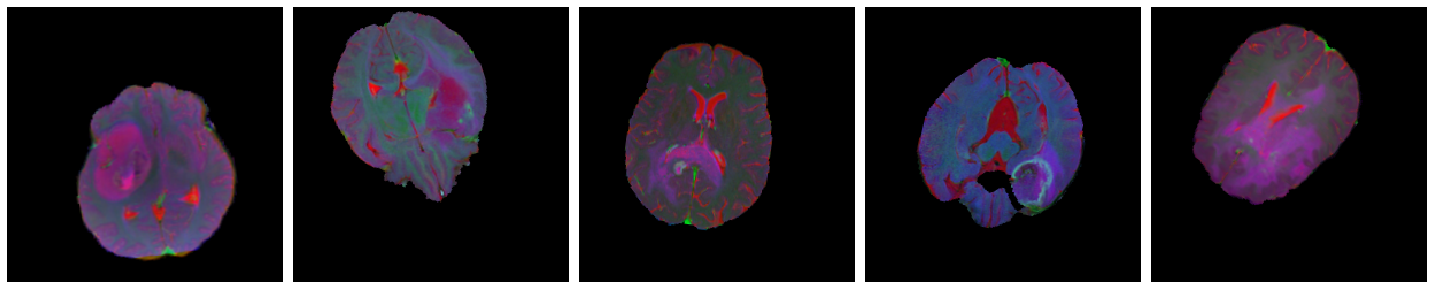

In [7]:
print(l[:5])
plots.plot_rgb_images(sample_training_images[:5])

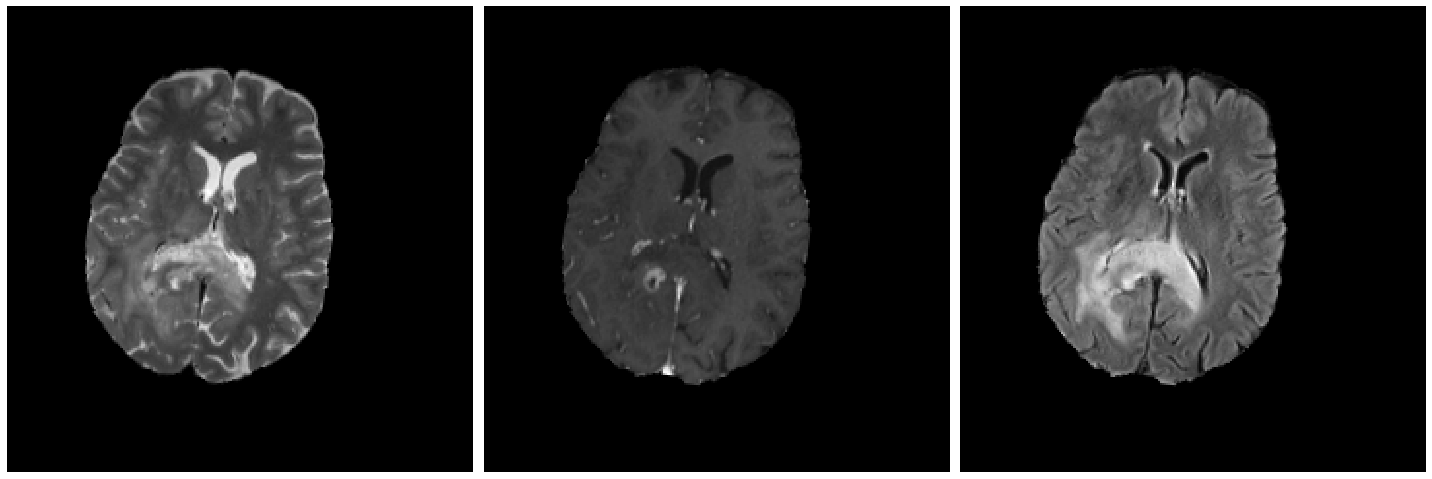

In [8]:
plots.plot_rgb_decomposition(sample_training_images[2])

In [9]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_a (Conv2D)              (None, 240, 240, 16)      448       
_________________________________________________________________
max_a (MaxPooling2D)         (None, 120, 120, 16)      0         
_________________________________________________________________
batch_norm (BatchNormalizati (None, 120, 120, 16)      64        
_________________________________________________________________
drop_a (Dropout)             (None, 120, 120, 16)      0         
_________________________________________________________________
conv_b (Conv2D)              (None, 120, 120, 32)      4640      
_________________________________________________________________
max_b (MaxPooling2D)         (None, 60, 60, 32)        0         
_________________________________________________________________
conv_c (Conv2D)              (None, 60, 60, 64)        18496     
__________

In [11]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size
)

# Save the model
model.save(model_path);

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
51/51 [==============================] - 18s 344ms/step - loss: 0.8578 - acc: 0.4985 - val_loss: 0.6858 - val_acc: 0.7188
Epoch 2/10
51/51 [==============================] - 16s 320ms/step - loss: 0.6441 - acc: 0.6446 - val_loss: 0.6017 - val_acc: 0.6919
Epoch 3/10
51/51 [==============================] - 17s 331ms/step - loss: 0.6005 - acc: 0.6760 - val_loss: 0.7064 - val_acc: 0.5808
Epoch 4/10
51/51 [==============================] - 16s 319ms/step - loss: 0.5390 - acc: 0.7346 - val_loss: 1.3369 - val_acc: 0.6061
Epoch 5/10
51/51 [==============================] - 17s 325ms/step - loss: 0.5229 - acc: 0.7425 - val_loss: 0.6580 - val_acc: 0.6389
Epoch 6/10
51/51 [==============================] - 17s 325ms/step - loss: 0.4783 - acc: 0.7620 - val_loss: 0.5927 - val_acc: 0.7273
Epoch 7/10
51/51 [==============================] - 17s 324ms/step - loss: 0.4411 - acc: 0.7884 - val_loss: 

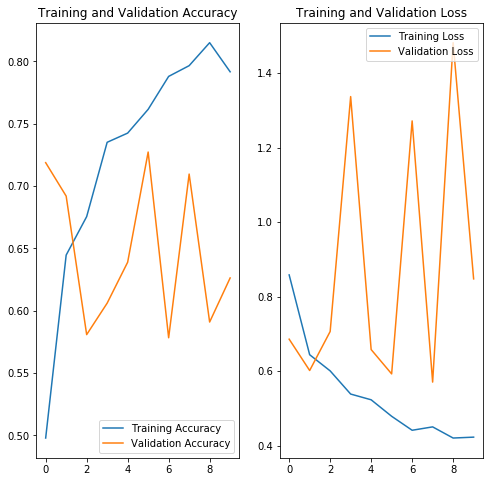

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()